링크 : https://wikidocs.net/22592

# **13. 서브워드 토크나이저 (Subword Tokenizer)**
---


## **13-01 바이트 페어 인코딩(Byte Pair Encoding, BPE)**

기계에게 아무리 많은 단어를 학습시켜도, 세상의 모든 단어를 알려줄 수는 없는 노릇입니다. 만약, 기계가 모르는 단어가 등장하면 그 단어를 단어 집합에 없는 단어란 의미에서 **OOV(Out‑Of‑Vocabulary)** 또는 **UNK(Unknown Token)** 라고 표현합니다. 기계가 문제를 풀 때, 모르는 단어가 등장하면 (사람도 마찬가지 지만) 주어진 문제를 푸는 것이 까다로워 집니다. 이와 같이 모르는 단어로 인해 문제를 푸는 것이 까다로워지는 상황을 OOV 문제라고 합니다.  
  

**서브워드 분리 (Subword segmenation)** 작업은 하나의 단어는 더 작은 단위의 의미있는 여러 서브워드들 (Ex) birthplace = birth + place) 의 조합으로 구성된 경우가 많기 때문에, 하나의 단어를 여러 서브워드로 분리해서 단어를 인코딩 및 임베딩하겠다는 의도를 가진 전처리 작업입니다. 이를 통해 OOV 나 희귀 단어, 신조어와 같은 문제를 완화시킬 수 있습니다. 실제로 언어의 특성에 따라 영어권 언어나 한국어는 서브워드 분리를 시도했을 때 어느정도 의미있는 단위로 나누는 것이 가능합니다. 이 책에서는 이런 작업을 하는 토크나이저를 서브워드 토크나이저라고 명명하겠습니다.  
  
이번 챕터에서는 서브워드 토크나이저의 주요 알고리즘인 바이트 페어 인코딩과 실제 실무에서 사용하는 서브워드 토크나이저 구현체인 **SentencePiece** 와 Huggingface의 **Tokenizers** 에 대해서 소개합니다.

### **1. BPE(Byte Pair Encoding)**

BPE(Byte pair encoding) 알고리즘은 1994년에 제안된 데이터 압축 알고리즘입니다. 하지만 후에 자연어 처리의 서브워드 분리 알고리즘으로 응용되었는데 이에 대해서는 뒤에 언급하도록 하고, 우선 기존의 BPE의 작동 방법에 대해서 이해해보겠습니다. 아래와 같은 문자열이 주어졌을 때 BPE을 수행한다고 해봅시다.

```yaml
    aaabdaaabac
```

BPE은 기본적으로 연속적으로 가장 많이 등장한 글자의 쌍을 찾아서 하나의 글자로 병합하는 방식을 수행합니다. 태생이 압축 알고리즘인 만큼, 여기서는 글자 대신 바이트(byte)라는 표현을 사용하겠습니다. 예를 들어 위의 문자열 중 가장 자주 등장하고 있는 바이트의 쌍(byte pair)은 'aa'입니다. 이 'aa'라는 바이트의 쌍을 하나의 바이트인 'Z'로 치환해보겠습니다.

```yaml
    ZabdZabac
    Z=aa
```

위 문자열 중에서 가장 많이 등장하고 있는 바이트의 쌍은 'ab'입니다. 이 'ab'를 'Y'로 치환해봅시다.

```yaml
    ZYdZYac
    Y=ab
    Z=aa
```

가장 많이 등장하고 있는 바이트의 쌍은 'ZY'입니다. 이를 'X'로 치환해봅시다.

```yaml
    XdXac
    X=ZY
    Y=ab
    Z=aa

```

더 이상 병합할 바이트의 쌍은 없으므로 BPE는 위의 결과를 최종 결과로 하여 종료됩니다.

---
### **2. 자연어 처리에서의 BPE(Byte Pair Encoding)**

논문 : https://arxiv.org/pdf/1508.07909.pdf

자연어 처리에서의 BPE는 서브워드 분리(subword segmentation) 알고리즘입니다. 기존에 있던 단어를 분리한다는 의미입니다. BPE을 요약하면, 글자(charcter) 단위에서 점차적으로 단어 집합(vocabulary)을 만들어 내는 Bottom up 방식의 접근을 사용합니다. 우선 훈련 데이터에 있는 단어들을 모든 글자(chracters) 또는 유니코드(unicode) 단위로 단어 집합(vocabulary)를 만들고, 가장 많이 등장하는 유니그램을 하나의 유니그램으로 통합합니다.

BPE을 자연어 처리에 사용한다고 제안한 논문(Sennrich et al. (2016))에서 이미 BPE의 코드를 공개하였기 때문에, 바로 파이썬 실습이 가능합니다. 코드 실습을 진행하기 전에 육안으로 확인할 수 있는 간단한 예를 들어보겠습니다.

#### **1) 기존의 접근**
어떤 훈련 데이터로부터 각 단어들의 빈도수를 카운트했다고 해보겠습니다. 그리고 각 단어와 각 단어의 빈도수가 기록되어져 있는 해당 결과는 임의로 딕셔너리(dictionary)란 이름을 붙였습니다.

```yaml
    # dictionary
    # 훈련 데이터에 있는 단어와 등장 빈도수
    low : 5, lower : 2, newest : 6, widest : 3
```

이 훈련 데이터에는 'low'란 단어가 5회 등장하였고, 'lower'란 단어는 2회 등장하였으며, 'newest'란 단어는 6회, 'widest'란 단어는 3회 등장하였다는 의미입니다. 그렇다면 딕셔너리로부터 이 훈련 데이터의 단어 집합(vocabulary)을 얻는 것은 간단합니다.

```yaml
    # vocabulary
    low, lower, newest, widest
```

단어 집합은 중복을 배제한 단어들의 집합을 의미하므로 기존에 배운 단어 집합의 정의라면, 이 훈련 데이터의 단어 집합에는 'low', 'lower', 'newest', 'widest'라는 4개의 단어가 존재합니다. 그리고 이 경우 테스트 과정에서 'lowest'란 단어가 등장한다면 기계는 이 단어를 학습한 적이 없으므로 해당 단어에 대해서 제대로 대응하지 못하는 OOV 문제가 발생합니다. 그렇다면 BPE를 적용한다면 어떨까요?

#### **2) BPE 알고리즘을 사용한 경우**

위의 딕셔너리에 BPE를 적용해봅시다. 우선 딕셔너리의 모든 단어들을 글자(chracter) 단위로 분리합니다. 이 경우 딕셔너리는 아래와 같습니다. 이제부터 딕셔너리는 자신 또한 업데이트되며 앞으로 단어 집합을 업데이트하기 위해 지속적으로 참고되는 참고 자료의 역할을 합니다.

```yaml
    # dictionary
    l o w : 5,  l o w e r : 2,  n e w e s t : 6,  w i d e s t : 3
```

딕셔너리를 참고로 한 초기 단어 집합(vocabulary)을 아래와 같습니다. 간단히 말해 초기 구성은 글자 단위로 분리된 상태입니다.

```yaml
    # vocabulary
    l, o, w, e, r, n, s, t, i, d
```

BPE의 특징은 알고리즘의 동작을 몇 회 반복(iteration)할 것인지를 사용자가 정한다는 점입니다. 여기서는 총 10회를 수행한다고 가정합니다. 다시 말해 **가장 빈도수가 높은 유니그램의 쌍을 하나의 유니그램으로 통합** 하는 과정을 총 10회 반복합니다. 위의 딕셔너리에 따르면 빈도수가 현재 가장 높은 유니그램의 쌍은 (e, s)입니다.

**1회 - 딕셔너리를 참고로 하였을 때 빈도수가 9로 가장 높은 (e, s)의 쌍을 es로 통합합니다.**

```yaml
    # dictionary update!
    l o w : 5,
    l o w e r : 2,
    n e w es t : 6,
    w i d es t : 3
```

```yaml
    # vocabulary update!
    l, o, w, e, r, n, s, t, i, d, es
```

**2회 - 빈도수가 9로 가장 높은 (es, t)의 쌍을 est로 통합합니다.**

```yaml
    # dictionary update!
    l o w : 5,
    l o w e r : 2,
    n e w est : 6,
    w i d est : 3
```

```yaml
    # vocabulary update!
    l, o, w, e, r, n, s, t, i, d, es, est
```

**3회 - 빈도수가 7로 가장 높은 (l, o)의 쌍을 lo로 통합합니다.**

```yaml
    # dictionary update!
    lo w : 5,
    lo w e r : 2,
    n e w est : 6,
    w i d est : 3
```

```yaml
    # vocabulary update!
    l, o, w, e, r, n, s, t, i, d, es, est, lo
```

이와 같은 방식으로 총 10회 반복하였을 때 얻은 딕셔너리와 단어 집합은 아래와 같습니다.

```yaml
    # dictionary update!
    low : 5,
    low e r : 2,
    newest : 6,
    widest : 3
```

```yaml
    # vocabulary update!
    l, o, w, e, r, n, s, t, i, d, es, est, lo, low, ne, new, newest, wi, wid, widest
```

이 경우 테스트 과정에서 'lowest'란 단어가 등장한다면, 기존에는 OOV에 해당되는 단어가 되었겠지만 BPE 알고리즘을 사용한 위의 단어 집합에서는 더 이상 'lowest'는 OOV가 아닙니다. 기계는 우선 'lowest'를 전부 글자 단위로 분할합니다. 즉, 'l, o, w, e, s, t'가 됩니다. 그리고 기계는 위의 단어 집합을 참고로 하여 'low'와 'est'를 찾아냅니다. 즉, 'lowest'를 기계는 'low'와 'est' 두 단어로 인코딩합니다. 그리고 이 두 단어는 둘 다 단어 집합에 있는 단어이므로 OOV가 아닙니다.

이 동작 과정을 그림으로 표현한다면 다음과 같습니다.

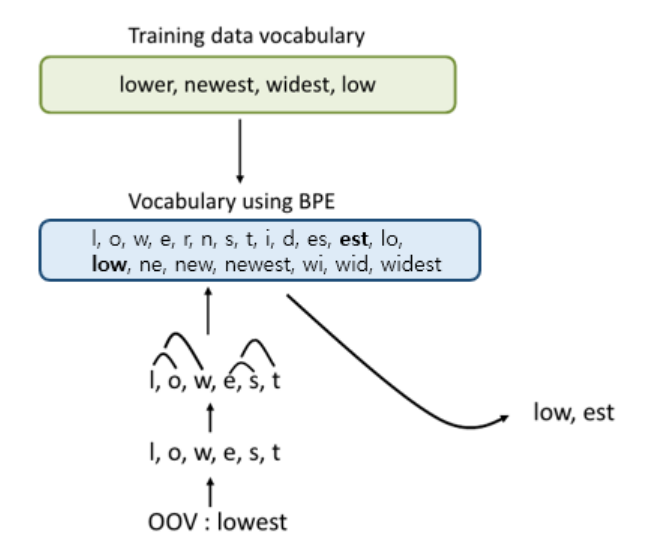

실제 코드를 통해 구현해봅시다.

#### **3) 코드 실습하기**

아래 코드는 원 논문에서 공개한 코드를 참고로 하여 수정한 코드입니다. 우선 필요한 도구들을 임포트합니다.

In [1]:
import re, collections
from IPython.display import display, Markdown, Latex

BPE을 몇 회 수행할 것인지를 정합니다. 여기서는 10회로 정했습니다.

In [2]:
num_merges = 10

BPE에 사용할 단어가 low, lower, newest, widest일 때, BPE의 입력으로 사용하는 실제 단어 집합은 아래와 같습니다. `</w>`는 단어의 맨 끝에 붙이는 특수 문자이며, 각 단어는 글자(character) 단위로 분리합니다.

In [3]:
dictionary = {'l o w </w>' : 5,
         'l o w e r </w>' : 2,
         'n e w e s t </w>':6,
         'w i d e s t </w>':3
         }

In [4]:
dictionary

{'l o w </w>': 5,
 'l o w e r </w>': 2,
 'n e w e s t </w>': 6,
 'w i d e s t </w>': 3}

In [5]:
p = collections.defaultdict(int)
p

defaultdict(int, {})

In [6]:
p['a'] = 10
p['b']
p['c'] += 1
p

defaultdict(int, {'a': 10, 'b': 0, 'c': 1})

In [7]:
p['a', 'c']

0

In [8]:
p

defaultdict(int, {'a': 10, 'b': 0, 'c': 1, ('a', 'c'): 0})

In [9]:
max(p, key=p.get)   # value가 최대인 key값 return

'a'

BPE의 코드는 아래와 같습니다. 알고리즘은 위에서 설명했던 것과 동일하게 가장 빈도수가 높은 유니그램의 쌍을 하나의 유니그램으로 통합하는 과정으로 num_merges회 반복합니다.

In [10]:
def get_stats(dictionary):
    # 유니그램의 pair들의 빈도수를 카운트
    pairs = collections.defaultdict(int)
    for word, freq in dictionary.items():
        symbols = word.split()
        for i in range(len(symbols)-1):
            pairs[symbols[i],symbols[i+1]] += freq  ## (symbols[i], symbols[i+1]) 이런 튜플을 키로 하는 k-v pair 생성
    print('현재 pair들의 빈도수 :', dict(pairs))
    return pairs

In [11]:

def merge_dictionary(pair, v_in):
    v_out = {}
    bigram = re.escape(' '.join(pair))
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
    for word in v_in:
        w_out = p.sub(''.join(pair), word)
        v_out[w_out] = v_in[word]
    return v_out


In [12]:
dictionary

{'l o w </w>': 5,
 'l o w e r </w>': 2,
 'n e w e s t </w>': 6,
 'w i d e s t </w>': 3}

In [13]:
get_stats(dictionary)

현재 pair들의 빈도수 : {('l', 'o'): 7, ('o', 'w'): 7, ('w', '</w>'): 5, ('w', 'e'): 8, ('e', 'r'): 2, ('r', '</w>'): 2, ('n', 'e'): 6, ('e', 'w'): 6, ('e', 's'): 9, ('s', 't'): 9, ('t', '</w>'): 9, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'e'): 3}


defaultdict(int,
            {('l', 'o'): 7,
             ('o', 'w'): 7,
             ('w', '</w>'): 5,
             ('w', 'e'): 8,
             ('e', 'r'): 2,
             ('r', '</w>'): 2,
             ('n', 'e'): 6,
             ('e', 'w'): 6,
             ('e', 's'): 9,
             ('s', 't'): 9,
             ('t', '</w>'): 9,
             ('w', 'i'): 3,
             ('i', 'd'): 3,
             ('d', 'e'): 3})

아래 코드를 실행하면 출력 결과는 아래와 같으며 이는 글자들의 통합 과정을 보여주고 있습니다.

In [14]:
bpe_codes = {}
bpe_codes_reverse = {}

for i in range(num_merges):  # 10회 반복
    display(Markdown("### Iteration {}".format(i + 1)))
    pairs = get_stats(dictionary)
    best = max(pairs, key=pairs.get)
    dictionary = merge_dictionary(best, dictionary)

    bpe_codes[best] = i
    bpe_codes_reverse[best[0] + best[1]] = best

    print("new merge: {}".format(best))
    print("dictionary: {}".format(dictionary))

### Iteration 1

현재 pair들의 빈도수 : {('l', 'o'): 7, ('o', 'w'): 7, ('w', '</w>'): 5, ('w', 'e'): 8, ('e', 'r'): 2, ('r', '</w>'): 2, ('n', 'e'): 6, ('e', 'w'): 6, ('e', 's'): 9, ('s', 't'): 9, ('t', '</w>'): 9, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'e'): 3}
new merge: ('e', 's')
dictionary: {'l o w </w>': 5, 'l o w e r </w>': 2, 'n e w es t </w>': 6, 'w i d es t </w>': 3}


### Iteration 2

현재 pair들의 빈도수 : {('l', 'o'): 7, ('o', 'w'): 7, ('w', '</w>'): 5, ('w', 'e'): 2, ('e', 'r'): 2, ('r', '</w>'): 2, ('n', 'e'): 6, ('e', 'w'): 6, ('w', 'es'): 6, ('es', 't'): 9, ('t', '</w>'): 9, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'es'): 3}
new merge: ('es', 't')
dictionary: {'l o w </w>': 5, 'l o w e r </w>': 2, 'n e w est </w>': 6, 'w i d est </w>': 3}


### Iteration 3

현재 pair들의 빈도수 : {('l', 'o'): 7, ('o', 'w'): 7, ('w', '</w>'): 5, ('w', 'e'): 2, ('e', 'r'): 2, ('r', '</w>'): 2, ('n', 'e'): 6, ('e', 'w'): 6, ('w', 'est'): 6, ('est', '</w>'): 9, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'est'): 3}
new merge: ('est', '</w>')
dictionary: {'l o w </w>': 5, 'l o w e r </w>': 2, 'n e w est</w>': 6, 'w i d est</w>': 3}


### Iteration 4

현재 pair들의 빈도수 : {('l', 'o'): 7, ('o', 'w'): 7, ('w', '</w>'): 5, ('w', 'e'): 2, ('e', 'r'): 2, ('r', '</w>'): 2, ('n', 'e'): 6, ('e', 'w'): 6, ('w', 'est</w>'): 6, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'est</w>'): 3}
new merge: ('l', 'o')
dictionary: {'lo w </w>': 5, 'lo w e r </w>': 2, 'n e w est</w>': 6, 'w i d est</w>': 3}


### Iteration 5

현재 pair들의 빈도수 : {('lo', 'w'): 7, ('w', '</w>'): 5, ('w', 'e'): 2, ('e', 'r'): 2, ('r', '</w>'): 2, ('n', 'e'): 6, ('e', 'w'): 6, ('w', 'est</w>'): 6, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'est</w>'): 3}
new merge: ('lo', 'w')
dictionary: {'low </w>': 5, 'low e r </w>': 2, 'n e w est</w>': 6, 'w i d est</w>': 3}


### Iteration 6

현재 pair들의 빈도수 : {('low', '</w>'): 5, ('low', 'e'): 2, ('e', 'r'): 2, ('r', '</w>'): 2, ('n', 'e'): 6, ('e', 'w'): 6, ('w', 'est</w>'): 6, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'est</w>'): 3}
new merge: ('n', 'e')
dictionary: {'low </w>': 5, 'low e r </w>': 2, 'ne w est</w>': 6, 'w i d est</w>': 3}


### Iteration 7

현재 pair들의 빈도수 : {('low', '</w>'): 5, ('low', 'e'): 2, ('e', 'r'): 2, ('r', '</w>'): 2, ('ne', 'w'): 6, ('w', 'est</w>'): 6, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'est</w>'): 3}
new merge: ('ne', 'w')
dictionary: {'low </w>': 5, 'low e r </w>': 2, 'new est</w>': 6, 'w i d est</w>': 3}


### Iteration 8

현재 pair들의 빈도수 : {('low', '</w>'): 5, ('low', 'e'): 2, ('e', 'r'): 2, ('r', '</w>'): 2, ('new', 'est</w>'): 6, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'est</w>'): 3}
new merge: ('new', 'est</w>')
dictionary: {'low </w>': 5, 'low e r </w>': 2, 'newest</w>': 6, 'w i d est</w>': 3}


### Iteration 9

현재 pair들의 빈도수 : {('low', '</w>'): 5, ('low', 'e'): 2, ('e', 'r'): 2, ('r', '</w>'): 2, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'est</w>'): 3}
new merge: ('low', '</w>')
dictionary: {'low</w>': 5, 'low e r </w>': 2, 'newest</w>': 6, 'w i d est</w>': 3}


### Iteration 10

현재 pair들의 빈도수 : {('low', 'e'): 2, ('e', 'r'): 2, ('r', '</w>'): 2, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'est</w>'): 3}
new merge: ('w', 'i')
dictionary: {'low</w>': 5, 'low e r </w>': 2, 'newest</w>': 6, 'wi d est</w>': 3}


bpe_codes를 출력하면 merge 했던 기록이 출력됩니다.



In [ ]:
print(bpe_codes)

{('e', 's'): 0, ('es', 't'): 1, ('est', '</w>'): 2, ('l', 'o'): 3, ('lo', 'w'): 4, ('n', 'e'): 5, ('ne', 'w'): 6, ('new', 'est</w>'): 7, ('low', '</w>'): 8, ('w', 'i'): 9}


이 기록은 새로운 단어가 등장하였을 때, 현재 가지고 있는 서브워드 단어 집합에 의거하여 분리하는 일에 참고할 수 있습니다.

#### **4) OOV에 대처하기**

In [15]:
def get_pairs(word):  
    """Return set of symbol pairs in a word. (문자 2개씩 묶은 튜플의 Set로 반환)
    Word is represented as a tuple of symbols (symbols being variable-length strings).
    """
    pairs = set()
    prev_char = word[0]
    for char in word[1:]:
        pairs.add((prev_char, char))
        prev_char = char
    return pairs

In [16]:
get_pairs('hello')

{('e', 'l'), ('h', 'e'), ('l', 'l'), ('l', 'o')}

In [17]:
def encode(orig):
    """Encode word based on list of BPE merge operations, which are applied consecutively"""

    word = tuple(orig) + ('</w>',)  # 튜플의 맨 뒤에 </w> 요소 추가하여 word 만들기
    display(Markdown("__word split into characters:__ <tt>{}</tt>".format(word)))   # <tt></tt> 고정폭 글꼴 적용

    pairs = get_pairs(word)    

    if not pairs:
        return orig

    iteration = 0
    while True:
        iteration += 1
        display(Markdown("__Iteration {}:__".format(iteration)))

        print("bigrams in the word: {}".format(pairs))
        bigram = min(pairs, key = lambda pair: bpe_codes.get(pair, float('inf')))
        print("candidate for merging: {}".format(bigram))
        if bigram not in bpe_codes:
            display(Markdown("__Candidate not in BPE merges, algorithm stops.__"))
            break
        first, second = bigram
        new_word = []
        i = 0
        while i < len(word):
            try:
                j = word.index(first, i)
                new_word.extend(word[i:j])
                i = j
            except:
                new_word.extend(word[i:])
                break

            if word[i] == first and i < len(word)-1 and word[i+1] == second:
                new_word.append(first+second)
                i += 2
            else:
                new_word.append(word[i])
                i += 1
        new_word = tuple(new_word)
        word = new_word
        print("word after merging: {}".format(word))
        if len(word) == 1:
            break
        else:
            pairs = get_pairs(word)

    # don't print end-of-word symbols
    if word[-1] == '</w>':
        word = word[:-1]
    elif word[-1].endswith('</w>'):
        word = word[:-1] + (word[-1].replace('</w>',''),)

    return word

단어 'loki'가 들어오면 BPE 알고리즘 해당 단어를 어떻게 분리할까요?

In [18]:
encode("loki")

__word split into characters:__ <tt>('l', 'o', 'k', 'i', '</w>')</tt>

__Iteration 1:__

bigrams in the word: {('o', 'k'), ('l', 'o'), ('k', 'i'), ('i', '</w>')}
candidate for merging: ('l', 'o')
word after merging: ('lo', 'k', 'i', '</w>')


__Iteration 2:__

bigrams in the word: {('lo', 'k'), ('k', 'i'), ('i', '</w>')}
candidate for merging: ('lo', 'k')


__Candidate not in BPE merges, algorithm stops.__

('lo', 'k', 'i')

현재 서브워드 단어집합에는 'lo'가 존재하므로, 'lo'는 유지하고 'k'와 'i'는 분리시킵니다. 단어 'lowest'에 대해서도 수행해봅시다.

In [19]:
encode("lowest")

__word split into characters:__ <tt>('l', 'o', 'w', 'e', 's', 't', '</w>')</tt>

__Iteration 1:__

bigrams in the word: {('l', 'o'), ('e', 's'), ('s', 't'), ('t', '</w>'), ('w', 'e'), ('o', 'w')}
candidate for merging: ('e', 's')
word after merging: ('l', 'o', 'w', 'es', 't', '</w>')


__Iteration 2:__

bigrams in the word: {('l', 'o'), ('es', 't'), ('t', '</w>'), ('w', 'es'), ('o', 'w')}
candidate for merging: ('es', 't')
word after merging: ('l', 'o', 'w', 'est', '</w>')


__Iteration 3:__

bigrams in the word: {('l', 'o'), ('est', '</w>'), ('w', 'est'), ('o', 'w')}
candidate for merging: ('est', '</w>')
word after merging: ('l', 'o', 'w', 'est</w>')


__Iteration 4:__

bigrams in the word: {('w', 'est</w>'), ('l', 'o'), ('o', 'w')}
candidate for merging: ('l', 'o')
word after merging: ('lo', 'w', 'est</w>')


__Iteration 5:__

bigrams in the word: {('w', 'est</w>'), ('lo', 'w')}
candidate for merging: ('lo', 'w')
word after merging: ('low', 'est</w>')


__Iteration 6:__

bigrams in the word: {('low', 'est</w>')}
candidate for merging: ('low', 'est</w>')


__Candidate not in BPE merges, algorithm stops.__

('low', 'est')

현재 서브워드 단어집합에 'low'와 'est'가 존재하므로, 'low'와 'est'를 분리시킵니다. 단어 'lowing'에 대해서도 수행해봅시다.

In [20]:
encode("lowing")

__word split into characters:__ <tt>('l', 'o', 'w', 'i', 'n', 'g', '</w>')</tt>

__Iteration 1:__

bigrams in the word: {('w', 'i'), ('l', 'o'), ('n', 'g'), ('i', 'n'), ('g', '</w>'), ('o', 'w')}
candidate for merging: ('l', 'o')
word after merging: ('lo', 'w', 'i', 'n', 'g', '</w>')


__Iteration 2:__

bigrams in the word: {('w', 'i'), ('n', 'g'), ('i', 'n'), ('lo', 'w'), ('g', '</w>')}
candidate for merging: ('lo', 'w')
word after merging: ('low', 'i', 'n', 'g', '</w>')


__Iteration 3:__

bigrams in the word: {('g', '</w>'), ('n', 'g'), ('low', 'i'), ('i', 'n')}
candidate for merging: ('g', '</w>')


__Candidate not in BPE merges, algorithm stops.__

('low', 'i', 'n', 'g')

현재 서브워드 단어집합에 'low'가 존재하지만, 'i', 'n', 'g'의 바이그램 조합으로 이루어진 서브워드는 존재하지 않으므로 'i', 'n', 'g'로 전부 분리합니다. 훈련된 데이터 중에서 어떤 서브워드도 존재하지 않는 'highing'은 어떨까요?

In [21]:
encode("highing")

__word split into characters:__ <tt>('h', 'i', 'g', 'h', 'i', 'n', 'g', '</w>')</tt>

__Iteration 1:__

bigrams in the word: {('n', 'g'), ('h', 'i'), ('i', 'n'), ('i', 'g'), ('g', 'h'), ('g', '</w>')}
candidate for merging: ('n', 'g')


__Candidate not in BPE merges, algorithm stops.__

('h', 'i', 'g', 'h', 'i', 'n', 'g')

모든 알파벳이 분리됩니다. BPE 외에도 BPE를 참고하여 만들어진 Wordpiece Tokenizer나 Unigram Language Model Tokenizer와 같은 서브워드 분리 알고리즘이 존재합니다. 이 두 알고리즘에 대해서는 간략히 이런 것들이 존재한다 정도로만 언급하고 넘어가겠습니다.

In [22]:
encode("lowering")

__word split into characters:__ <tt>('l', 'o', 'w', 'e', 'r', 'i', 'n', 'g', '</w>')</tt>

__Iteration 1:__

bigrams in the word: {('l', 'o'), ('e', 'r'), ('n', 'g'), ('i', 'n'), ('r', 'i'), ('w', 'e'), ('g', '</w>'), ('o', 'w')}
candidate for merging: ('l', 'o')
word after merging: ('lo', 'w', 'e', 'r', 'i', 'n', 'g', '</w>')


__Iteration 2:__

bigrams in the word: {('e', 'r'), ('n', 'g'), ('i', 'n'), ('r', 'i'), ('lo', 'w'), ('w', 'e'), ('g', '</w>')}
candidate for merging: ('lo', 'w')
word after merging: ('low', 'e', 'r', 'i', 'n', 'g', '</w>')


__Iteration 3:__

bigrams in the word: {('e', 'r'), ('n', 'g'), ('i', 'n'), ('r', 'i'), ('low', 'e'), ('g', '</w>')}
candidate for merging: ('e', 'r')


__Candidate not in BPE merges, algorithm stops.__

('low', 'e', 'r', 'i', 'n', 'g')

In [23]:
#######################################
# encode(orig) 함수 풀어보기
#######################################
orig = 'lowing'

"""Encode word based on list of BPE merge operations, which are applied consecutively"""

word = tuple(orig) + ('</w>',)  # 튜플의 맨 뒤에 </w> 요소 추가하여 word 만들기
word

('l', 'o', 'w', 'i', 'n', 'g', '</w>')

In [24]:
print(word)

('l', 'o', 'w', 'i', 'n', 'g', '</w>')


* markdown에서 \<\/w\>가 여떻게 보이는지
<tt></w></tt>

In [25]:
display(Markdown("__word split into characters:__ <tt>{}</tt>".format(word)))   # <tt></tt> 고정폭 글꼴 적용

__word split into characters:__ <tt>('l', 'o', 'w', 'i', 'n', 'g', '</w>')</tt>

In [26]:
pairs = get_pairs(word)    
pairs

{('g', '</w>'), ('i', 'n'), ('l', 'o'), ('n', 'g'), ('o', 'w'), ('w', 'i')}

In [27]:
bpe_codes

{('e', 's'): 0,
 ('es', 't'): 1,
 ('est', '</w>'): 2,
 ('l', 'o'): 3,
 ('lo', 'w'): 4,
 ('n', 'e'): 5,
 ('ne', 'w'): 6,
 ('new', 'est</w>'): 7,
 ('low', '</w>'): 8,
 ('w', 'i'): 9}

In [28]:
bpe_codes.get(('new', 'est</w>'), float('inf'))

7

In [29]:
key = lambda pair: bpe_codes.get(pair, float('inf'))
key

<function __main__.<lambda>(pair)>

In [30]:
for pair in pairs:
    print(pair, bpe_codes.get(pair, float('inf')))  # 키가 없을 때는 inf..

('w', 'i') 9
('l', 'o') 3
('n', 'g') inf
('i', 'n') inf
('g', '</w>') inf
('o', 'w') inf


In [31]:
bigram = min(pairs, key = lambda pair: bpe_codes.get(pair, float('inf')))
bigram

('l', 'o')

In [ ]:
iteration = 0
while True:
    iteration += 1
    display(Markdown("__Iteration {}:__".format(iteration)))

    print("bigrams in the word: {}".format(pairs))
    bigram = min(pairs, key = lambda pair: bpe_codes.get(pair, float('inf')))
    print("candidate for merging: {}".format(bigram))
    if bigram not in bpe_codes:
        display(Markdown("__Candidate not in BPE merges, algorithm stops.__"))
        break
    first, second = bigram
    new_word = []
    i = 0
    while i < len(word):
        try:
            j = word.index(first, i)
            new_word.extend(word[i:j])
            i = j
        except:
            new_word.extend(word[i:])
            break

        if word[i] == first and i < len(word)-1 and word[i+1] == second:
            new_word.append(first+second)
            i += 2
        else:
            new_word.append(word[i])
            i += 1
    new_word = tuple(new_word)
    word = new_word
    print("word after merging: {}".format(word))
    if len(word) == 1:
        break
    else:
        pairs = get_pairs(word)
word

__Iteration 1:__

bigrams in the word: {('i', 'n'), ('g', '</w>'), ('l', 'o'), ('n', 'g'), ('w', 'i'), ('o', 'w')}
candidate for merging: ('l', 'o')
word after merging: ('lo', 'w', 'i', 'n', 'g', '</w>')


__Iteration 2:__

bigrams in the word: {('i', 'n'), ('g', '</w>'), ('lo', 'w'), ('n', 'g'), ('w', 'i')}
candidate for merging: ('lo', 'w')
word after merging: ('low', 'i', 'n', 'g', '</w>')


__Iteration 3:__

bigrams in the word: {('i', 'n'), ('g', '</w>'), ('low', 'i'), ('n', 'g')}
candidate for merging: ('i', 'n')


__Candidate not in BPE merges, algorithm stops.__

('low', 'i', 'n', 'g', '</w>')

In [ ]:
# don't print end-of-word symbols
if word[-1] == '</w>':
    word = word[:-1]     # 마지막 토큰 심볼 '</w>' 는 word에서 배제
elif word[-1].endswith('</w>'):
    word = word[:-1] + (word[-1].replace('</w>',''),)

word

('low', 'i', 'n', 'g')

---
### **3. WordPiece Tokenizer**

논문 : https://static.googleusercontent.com/media/research.google.com/ko//pubs/archive/37842.pdf
구글이 위 WordPiece Tokenizer를 변형하여 번역기에 사용했다는 논문 : https://arxiv.org/pdf/1609.08144.pdf

WordPiece Tokenizer은 BPE의 변형 알고리즘입니다. 해당 알고리즘은 BPE가 빈도수에 기반하여 가장 많이 등장한 쌍을 병합하는 것과는 달리, 병합되었을 때 코퍼스의 우도(Likelihood)를 가장 높이는 쌍을 병합합니다. 2016년의 위 논문에서 구글은 구글 번역기에서 WordPiece Tokenizer가 수행된 결과에 대해서 기술하였습니다.

수행하기 이전의 문장: Jet makers feud over seat width with big orders at stake
WordPiece Tokenizer를 수행한 결과(wordpieces): _J et _makers _fe ud _over _seat _width _with _big _orders _at _stake

Jet는 J와 et로 나누어졌으며, feud는 fe와 ud로 나누어진 것을 볼 수 있습니다. WordPiece Tokenizer는 모든 단어의 맨 앞에 _를 붙이고, 단어는 서브 워드(subword)로 통계에 기반하여 띄어쓰기로 분리합니다. 여기서 언더바 _는 문장 복원을 위한 장치입니다.

예컨대, WordPiece Tokenizer의 결과로 나온 문장을 보면, Jet → _J et와 같이 기존에 없던 띄어쓰기가 추가되어 서브 워드(subwords)들을 구분하는 구분자 역할을 하고 있습니다. 그렇다면 기존에 있던 띄어쓰기와 구분자 역할의 띄어쓰기는 어떻게 구별할까요? 이 역할을 수행하는 것이 단어들 앞에 붙은 언더바 _입니다. WordPiece Tokenizer이 수행된 결과로부터 다시 수행 전의 결과로 돌리는 방법은 현재 있는 모든 띄어쓰기를 전부 제거하고, 언더바를 띄어쓰기로 바꾸면 됩니다.

이 알고리즘은 유명 딥 러닝 모델 BERT를 훈련하기 위해서 사용되기도 하였습니다.

---
### **4. Unigram Language Model Tokenizer**

논문 : https://arxiv.org/pdf/1804.10959.pdf

유니그램 언어 모델 토크나이저는 각각의 서브워드들에 대해서 손실(loss)을 계산합니다. 여기서 서브 단어의 손실이라는 것은 해당 서브워드가 단어 집합에서 제거되었을 경우, 코퍼스의 우도(Likelihood)가 감소하는 정도를 말합니다. 이렇게 측정된 서브워드들을 손실의 정도로 정렬하여, 최악의 영향을 주는 10~20%의 토큰을 제거합니다. 이를 원하는 단어 집합의 크기에 도달할 때까지 반복합니다.

지금까지 서브워드 토크나이징 알고리즘들에 대해서 정리해보았습니다. 이어서 이를 실무에서 사용하기 위한 패키지인 센텐스피스(SentencePiece)나 토크나이저스(tokenizers)의 사용법에 대해서 학습합니다.

마지막 편집일시 : 2022년 11월 16일 3:02 오후